In [1]:
from importlib import reload
from datetime import datetime
from my_functions import read_data
from my_functions import data_visualization as dv
from my_functions import my_svr
from my_functions import my_errors
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

A hotel's elec data  
Aggregate 15min elec data to **hourly** data.  
Weather data may not have hourly data, in this example, weather data is observed each 3 hours.  
Use ffill method to fill NaN values. 

In [2]:
elec_data_path = './elec_data/hhy.xlsx'
weather_data_path = './weather_data/weather_data_20170101-20170507_Shaoguan.csv'

elec = read_data.elec(elec_data_path, scale='H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

** big_data has too many columns, only keep those important ones. **

In [3]:
elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head(15)

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,133.700,78.0,10.0
2017-01-15 01:00:00,135.200,78.0,10.0
2017-01-15 02:00:00,136.700,78.0,10.0
2017-01-15 03:00:00,136.325,78.0,10.0
2017-01-15 04:00:00,136.825,78.0,10.0
2017-01-15 05:00:00,138.200,86.0,10.0
2017-01-15 06:00:00,135.950,86.0,10.0
2017-01-15 07:00:00,134.700,86.0,10.0
2017-01-15 08:00:00,132.825,87.0,9.0


# Explore the data, some plots

** elec usage not quite stable **

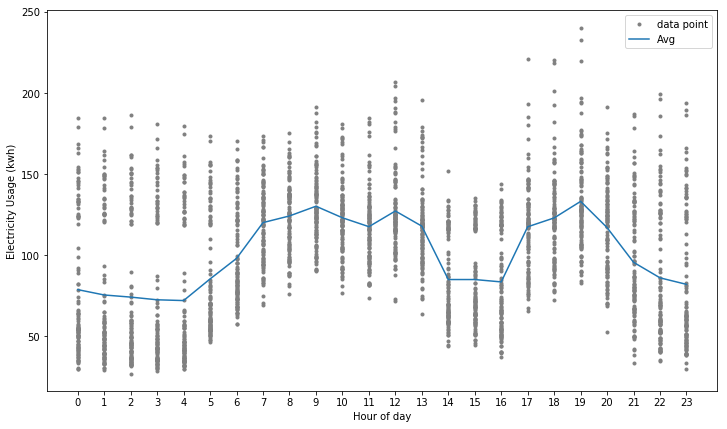

In [4]:
dv.plot_elec_hourly(elec_and_weather)

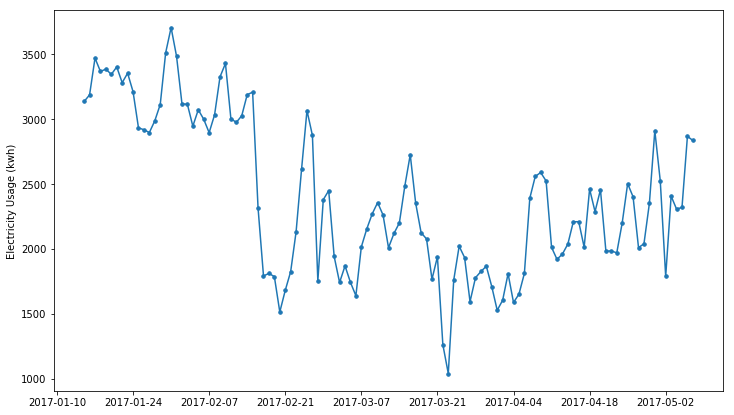

In [5]:
dv.plot_elec_daily(elec_and_weather)

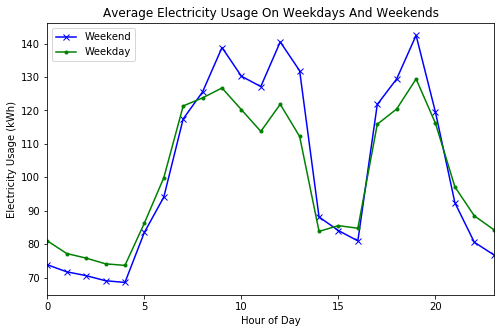

In [6]:
dv.compare_weekday_weekend(elec_and_weather)

** elec usage is both high when temperature is too low or too high **

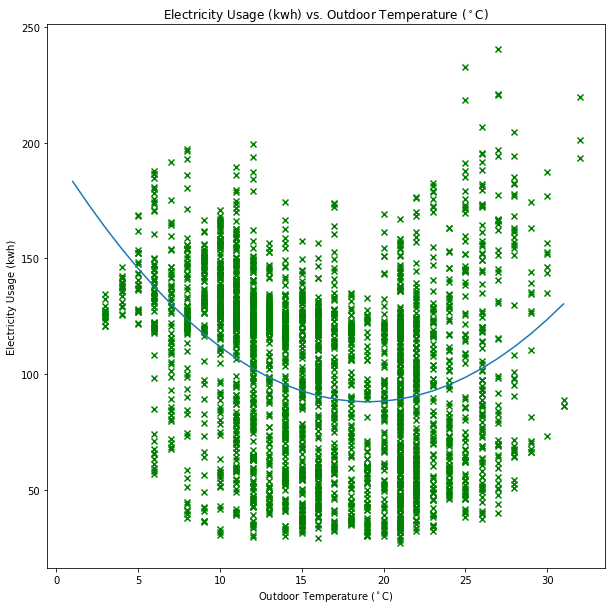

In [7]:
dv.compare_elec_temp(elec_and_weather.dropna())
p2 = np.poly1d(np.polyfit(elec_and_weather.dropna()['tempm'], elec_and_weather.dropna()['kwh'], 2))
plt.plot(range(1, 32), p2(range(1, 32)))
#p3 = np.poly1d(np.polyfit(elec_and_weather.dropna()['tempm'], elec_and_weather.dropna()['kwh'], 3))
#plt.plot(range(1, 32), p3(range(1, 32)))

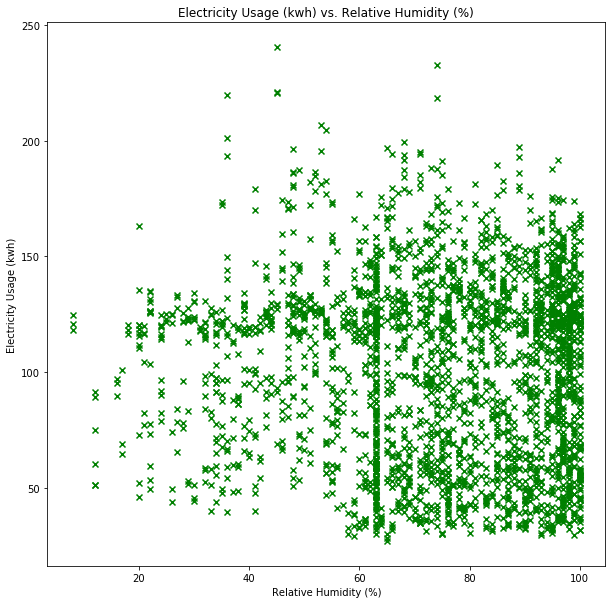

In [8]:
dv.compare_elec_hum(elec_and_weather.dropna())

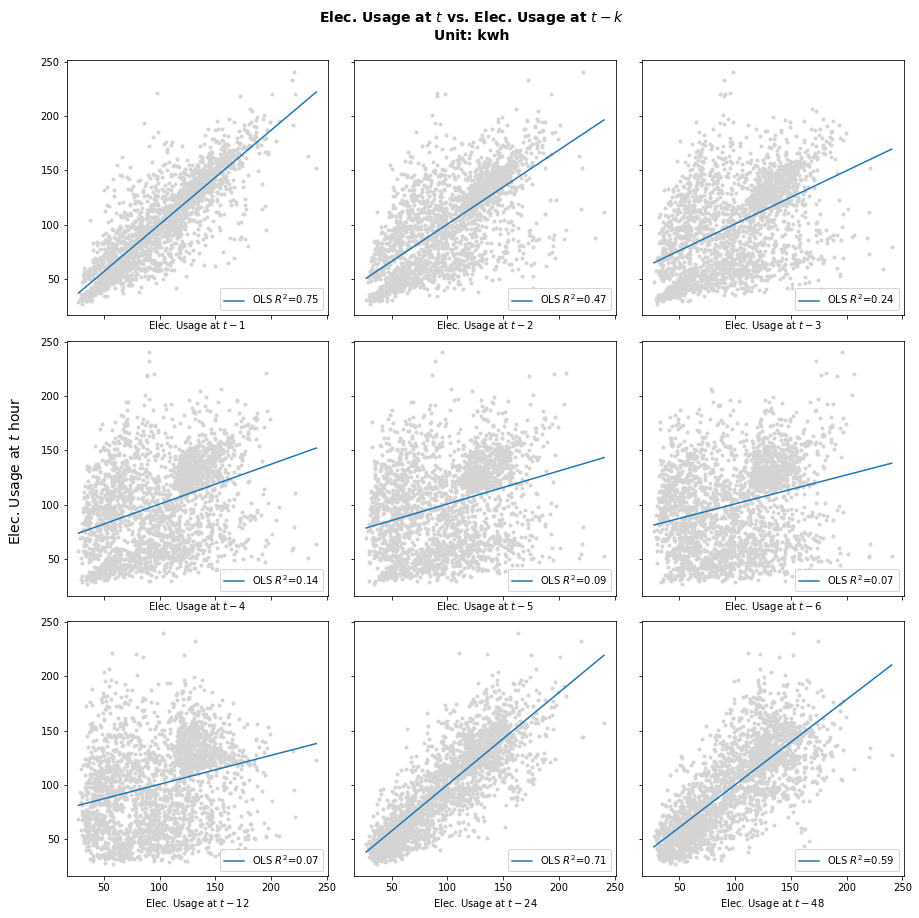

In [9]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather.dropna())

# add features -> split -> scale (also scale 0/1s)

** These values are 0/1s, maybe there's no need to scale them **

In [10]:
holidays=['2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '4/3/2017', '4/4/2017', '5/1/2017']
workdays=['4/1/2017']
split_date = ['1/17/2017', '4/27/2017', '4/28/2017', '5/2/2017', '5/3/2017', '5/7/2017']
cross_set_dates = ['2017-04-28', '2017-04-29', '2017-04-30', '2017-05-01', '2017-05-02']
test_set_dates = ['2017-05-03', '2017-05-04', '2017-05-05', '2017-05-06', '2017-05-07']

In [11]:
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
my_svr.add_hour_of_day(elec_and_weather)

drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)
X_train.head()

,hum,tempm,kwh_t-1,kwh_t-24,if_holiday,0,1,2,3,4,...,14,15,16,17,18,19,20,21,22,23
stat_time,,,,,,,,,,,,,,,,,,,,,
2017-01-17 00:00:00,92.0,9.0,152.075,137.075,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 01:00:00,92.0,9.0,151.075,130.075,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 02:00:00,99.0,9.0,149.075,129.325,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 03:00:00,99.0,9.0,150.700,133.325,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 04:00:00,99.0,9.0,152.825,131.700,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


** scaled data are arrays, reconstruct them to DataFrame for convenient use **

In [12]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

** Tricky part, you can not use historical data in the test set to do predction.  
I have to predcit kwh hour by hour, when i do the hour 0 prediction, the kwh_t-1 is known(yesterday 23).  
But when i do the hour 1 prediction, the kwh_t-1 is the predicted hour 0 value, not the actual hour 0 value. **

                  MAE       MAPE       RMSE          Obs         Pred  \
stat_time                                                               
2017-04-28  11.567748  13.509397  15.923707  2039.655050  1932.841259   
2017-04-29  13.846905  12.150601  19.429984  2351.080215  2023.217304   
2017-04-30  28.585286  17.404385  42.114805  2912.157127  2263.421513   
2017-05-01  18.122123  20.578508  21.690268  2526.549644  2391.066364   
2017-05-02  13.289638  22.230090  16.443992  1788.633359  2066.904868   

                 err%  
stat_time              
2017-04-28  -5.236856  
2017-04-29 -13.945203  
2017-04-30 -22.276807  
2017-05-01  -5.362383  
2017-05-02  15.557772  
{'RMSE': 25.082336761796782, 'MAE': 17.082339840652445, 'MAPE': 17.17459624798273}


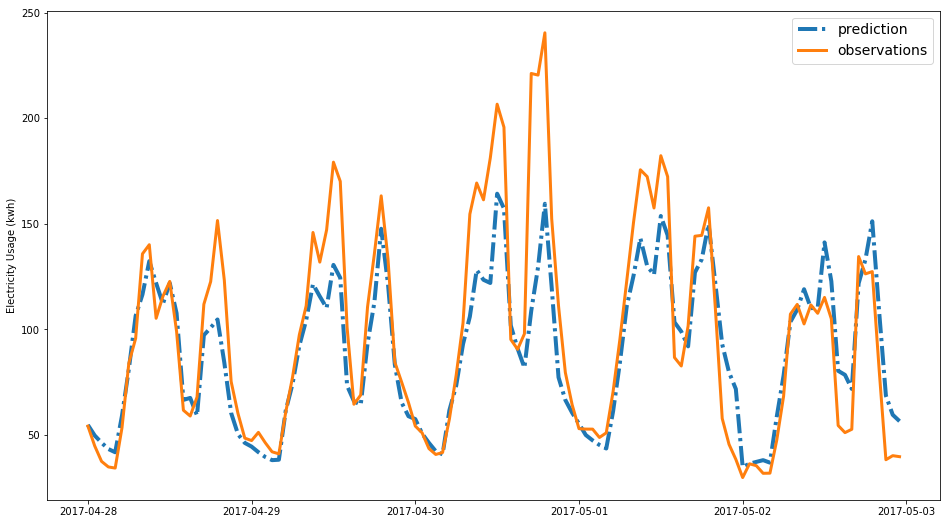

In [13]:
model = svm.SVR(kernel='rbf', C=100).fit(df_X_train_scaled, y_train)
result, df_err = my_svr.predict_many_days(model, scaler, df_X_cross_scaled, y_cross,
                                          cross_set_dates, scale='H')
print(df_err)
dv.plot_pred(y_cross, result)
# will print out the overalll erros

                  MAE       MAPE       RMSE          Obs         Pred  \
stat_time                                                               
2017-04-28  13.443822  16.113948  17.538961  2039.655050  1918.182166   
2017-04-29  19.952491  15.795926  29.096284  2351.080215  1873.958611   
2017-04-30  35.563528  22.118509  51.794708  2912.157127  2157.473213   
2017-05-01  28.867663  34.991865  37.031050  2526.549644  2592.144710   
2017-05-02  21.567713  38.065543  27.060616  1788.633359  2266.814994   

                 err%  
stat_time              
2017-04-28  -5.955560  
2017-04-29 -20.293719  
2017-04-30 -25.914945  
2017-05-01   2.596231  
2017-05-02  26.734469  
{'RMSE': 34.468757557525656, 'MAE': 23.879043091900957, 'MAPE': 25.41715816838515}


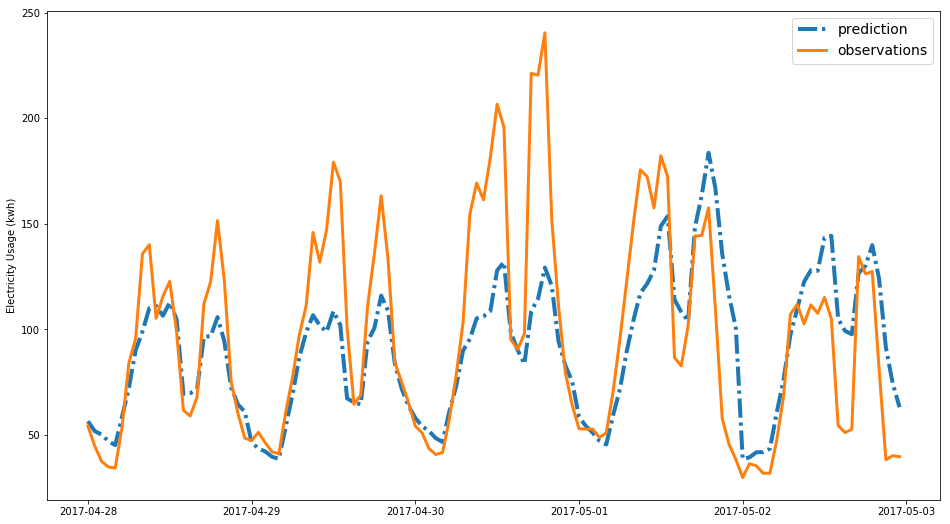

In [14]:
model = svm.SVR(kernel='linear', C=100).fit(df_X_train_scaled, y_train)
result, df_err = my_svr.predict_many_days(model, scaler, df_X_cross_scaled, y_cross,
                                          cross_set_dates, scale='H')
print(df_err)
dv.plot_pred(y_cross, result)
# will print out the overalll erros

In [15]:
df_err

,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-04-28,13.443822,16.113948,17.538961,2039.655050,1918.182166,-5.955560
2017-04-29,19.952491,15.795926,29.096284,2351.080215,1873.958611,-20.293719
2017-04-30,35.563528,22.118509,51.794708,2912.157127,2157.473213,-25.914945
2017-05-01,28.867663,34.991865,37.031050,2526.549644,2592.144710,2.596231
2017-05-02,21.567713,38.065543,27.060616,1788.633359,2266.814994,26.734469


# add features -> split -> scale (don't scale 0/1s)

** scale hum, temp, kwh and so on first, then add if_holiday, hour_of_day **

In [16]:
my_svr.delete_hour_of_day(elec_and_weather)
my_svr.delete_if_holiday(elec_and_weather)
elec_and_weather.head()

,kwh,hum,tempm,kwh_t-1,kwh_t-2,kwh_t-3,kwh_t-4,kwh_t-5,kwh_t-6,kwh_t-12,kwh_t-24,kwh_t-48
stat_time,,,,,,,,,,,,
2017-01-15 00:00:00,133.700,78.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15 01:00:00,135.200,78.0,10.0,133.700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15 02:00:00,136.700,78.0,10.0,135.200,133.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15 03:00:00,136.325,78.0,10.0,136.700,135.2,133.7,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15 04:00:00,136.825,78.0,10.0,136.325,136.7,135.2,133.7,NaN,NaN,NaN,NaN,NaN


In [17]:
drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

In [18]:
scaler2 = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler2.transform(X_train)
X_cross_scaled = scaler2.transform(X_cross)
X_test_scaled = scaler2.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


** Add 0/1s features **

In [19]:
my_svr.add_hour_of_day(df_X_train_scaled)
my_svr.add_hour_of_day(df_X_cross_scaled)
my_svr.add_hour_of_day(df_X_test_scaled)
my_svr.add_if_holiday(df_X_train_scaled, ['2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30',
               '2017-01-31', '2017-02-01', '2017-02-02', '4/3/2017', '4/4/2017'], workdays)
my_svr.add_if_holiday(df_X_cross_scaled, holidays=['5/1/2017'])
my_svr.add_if_holiday(df_X_test_scaled)

df_X_train_scaled.head()

,hum,tempm,kwh_t-1,kwh_t-24,0,1,2,3,4,5,...,15,16,17,18,19,20,21,22,23,if_holiday
stat_time,,,,,,,,,,,,,,,,,,,,,
2017-01-17 00:00:00,0.845815,-1.169515,1.330078,0.934333,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 01:00:00,0.845815,-1.169515,1.304117,0.752458,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 02:00:00,1.179043,-1.169515,1.252195,0.732971,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 03:00:00,1.179043,-1.169515,1.294381,0.836900,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 04:00:00,1.179043,-1.169515,1.349549,0.794679,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


** SVR **

In [20]:
model2 = svm.SVR(kernel='rbf', C=100).fit(df_X_train_scaled, y_train)

In [21]:
result, df_err = my_svr.predict_many_days(model2, scaler2, df_X_cross_scaled, y_cross,
                                          cross_set_dates, scale='H')

{'RMSE': 25.997498236107983, 'MAE': 17.736260841990244, 'MAPE': 19.286715795333937}


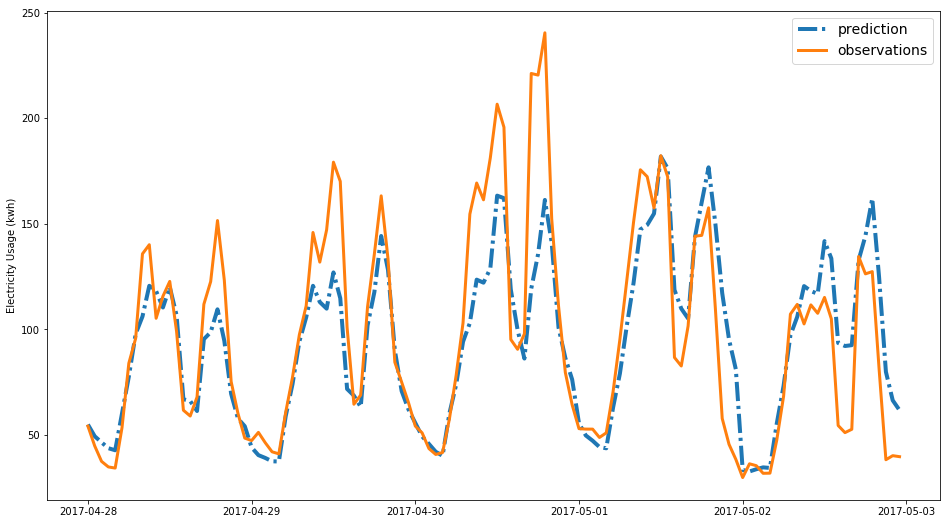

In [22]:
dv.plot_pred(y_cross, result)

** scale 0/1s seems to be better **

# Tune parameters: Grid Search

In [23]:
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
my_svr.add_hour_of_day(elec_and_weather)

drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_1h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [24]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [25]:
search_result['linear']

C,1,10,100,1000
MAE,23.634364,23.860670,23.879043,23.884556
MAPE,25.171229,25.392700,25.417158,25.427934
RMSE,32.157024,32.476524,32.504324,32.509763


In [26]:
search_result['rbf']

MAE                                        MAPE             \
C            1          10         100        1000       1          10     
gamma                                                                      
0.0001  42.458153  37.626437  22.145353  23.286049  64.837049  56.237785   
0.0005  40.343404  23.933474  22.679455  22.622437  61.060443  28.044969   
0.001   37.863048  22.070424  22.842349  21.491547  56.670779  23.566309   
0.005   25.971518  21.626940  19.887809  17.427148  32.333115  22.690777   
0.01    22.681849  20.750803  18.409720  16.472494  25.073789  21.636125   
0.05    23.156128  19.457264  17.201542  18.615850  25.454158  19.394425   
0.1     26.499100  19.924337  17.718462  20.750637  32.432763  20.060176   
0.5     37.693564  22.694916  21.180375  22.003715  54.926652  23.151780   
auto    22.086435  19.290453  17.082340  17.893188  23.521464  19.533412   

                                   RMSE                                   
C            100        1000       1          10         100        1000  
gamma                                                                     
0.0001  23.643884  24.810828  49.469751  44.283785  29.511063  31.664615  
0.0005  24.057014  23.937678  47.218538  30.452402  30.856555  31.029056  
0.001   24.192665  22.642339  44.544604  29.402484  31.159716  29.485584  
0.005   20.994563  17.980078  31.998172  29.513338  27.310121  23.811910  
0.01    19.362048  16.924047  29.443829  28.467748  25.245835  22.355588  
0.05    17.743709  19.567898  29.881881  26.053782  23.196703  24.961830  
0.1     18.552485  21.284136  33.132786  26.524480  23.641681  28.649281  
0.5     21.371319  22.054455  44.599018  30.144913  28.941541  30.430647  
auto    17.174596  19.199578  28.836181  26.113065  23.120551  23.920683

In [27]:
search_result['poly']

MAE                                        MAPE             \
C            1          10         100        1000       1          10     
degree                                                                     
2       28.180300  20.950921  20.872078  21.126948  37.096228  23.387801   
3       23.783898  19.968817  19.295279  20.359830  28.258211  20.943571   
4       24.226751  19.146645  18.520517  23.023363  29.035070  19.569085   
5       24.387377  19.544301  19.275595  23.035823  29.414744  20.161222   
6       24.793505  19.842213  20.531541  28.357339  30.246023  20.459363   
7       25.504042  20.181773  21.815554  29.333667  31.789237  20.792734   

                                   RMSE                                   
C            100        1000       1          10         100        1000  
degree                                                                    
2       22.919310  22.400858  34.393485  27.779461  27.074066  28.407449  
3       19.561203  20.808493  29.825664  25.898238  25.162088  26.676374  
4       19.157542  23.763260  30.385385  25.434508  24.391809  31.667540  
5       20.285615  23.926942  30.499155  25.630850  25.177566  32.122658  
6       21.380956  29.364087  30.900853  25.891878  26.869597  42.060876  
7       22.524350  29.801794  31.520396  26.292033  28.619923  45.364272

** C = 1000, gamma = 0.01, min RMSE, min MAPE, min MAE **

# Final Test

{'RMSE': 28.183378747777297, 'MAE': 20.205256589633656, 'MAPE': 17.355133166842037}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,24.799170,20.244830,35.044416,2407.664933,1876.223308,-22.072906
2017-05-04,14.659073,14.869187,21.744410,2307.330127,2138.323518,-7.324769
2017-05-05,17.363329,19.332831,22.179046,2320.526866,2294.448137,-1.123828
2017-05-06,22.680115,16.397881,30.359236,2868.751045,2324.428280,-18.974207
2017-05-07,21.524595,15.930938,29.274399,2836.405726,2426.411814,-14.454699


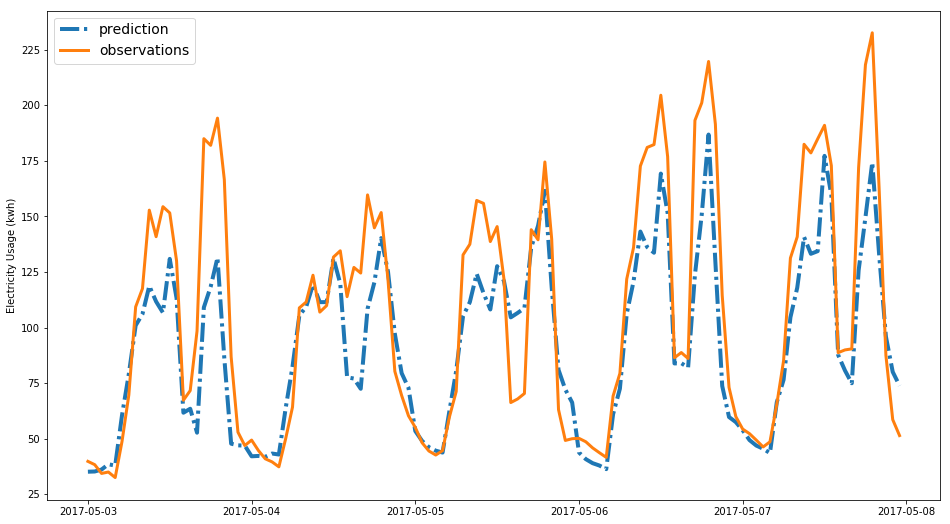

In [28]:
final_model = svm.SVR(kernel='rbf', C=1000, gamma=0.01).fit(df_X_train_scaled, y_train)
result_1h, df_err_1h = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_1h,
                                          test_set_dates, scale='H')
dv.plot_pred(y_test_1h, result_1h)
df_err_1h

# Different Time Scale

The original elec data is in 15min interval, the prediciton above uses 1 hour data aggregation.  

So here I'm trying aggregating data into different interval, or time scale, whatever you want to call it shit I don't know.  


## Half hour

In [29]:
elec = read_data.elec(elec_data_path, scale='30min')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,66.725,78.0,10.0
2017-01-15 00:30:00,66.975,NaN,NaN
2017-01-15 01:00:00,65.600,78.0,10.0
2017-01-15 01:30:00,69.600,NaN,NaN
2017-01-15 02:00:00,68.350,78.0,10.0


In [30]:
elec_and_weather.drop(elec_and_weather[elec_and_weather.kwh.isnull()].index, inplace=True)
elec_and_weather = elec_and_weather.fillna(method='ffill')

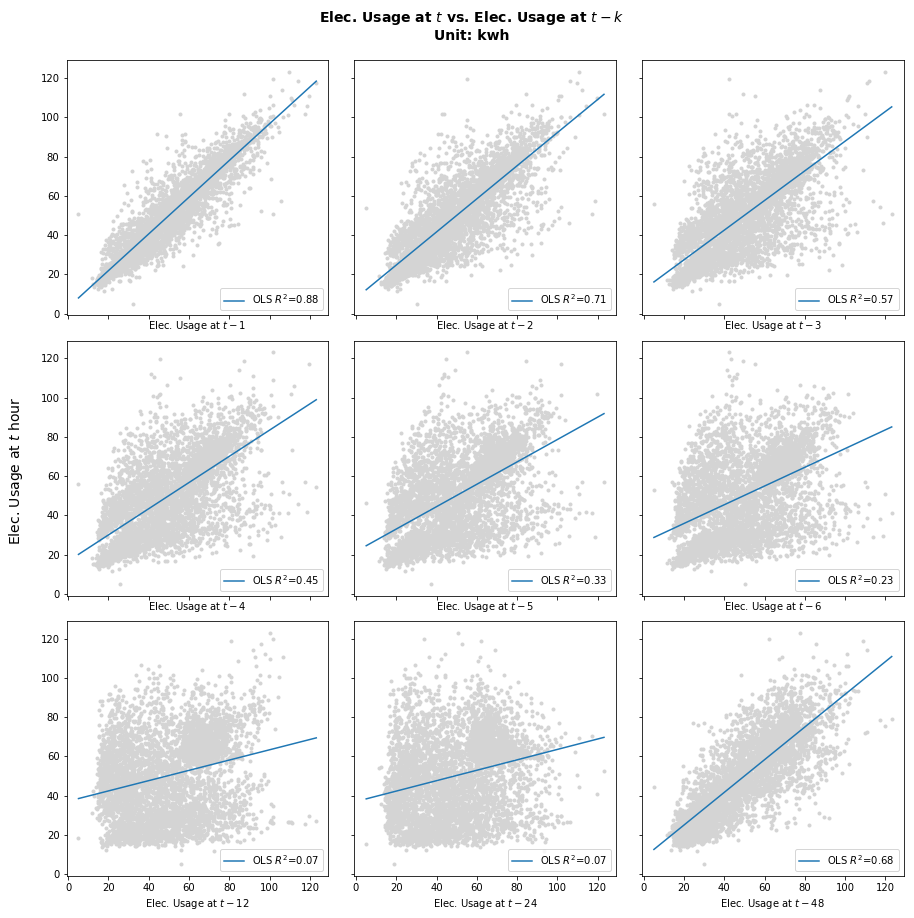

In [31]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

add features, split, scale  
** choose historical data differently **

In [32]:
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_historical_kwh(elec_and_weather)

drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-24', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_30min = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)

scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

** Grid Search **

In [33]:
parameters = {'kernel': ['linear', 'rbf'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='30min')

Testing linear kernel...
Testing rbf kernel...
Done.


In [34]:
search_result['linear']

C,1,10,100,1000
MAE,16.434716,16.537404,16.536530,16.540260
MAPE,28.594038,28.717030,28.721973,28.709136
RMSE,21.909863,22.044272,22.043269,22.053958


In [35]:
search_result['rbf']

MAE                                        MAPE             \
C            1          10         100        1000       1          10     
gamma                                                                      
0.0001  21.225266  17.294014  15.256153  15.684791  63.925725  45.614305   
0.0005  19.491631  14.169513  15.040573  12.484168  56.329844  26.609510   
0.001   17.390573  14.866272  13.706703  10.472398  46.194442  27.190625   
0.005   13.727798  12.379353  10.194219  10.687340  26.561648  23.522462   
0.01    13.154217  11.020770  10.669980  11.377485  24.909630  21.296639   
0.05    11.308770  10.853517  10.577214  10.846708  22.182031  21.882302   
0.1     11.330730  11.288591  10.875278  11.088731  22.938381  23.398731   
0.5     13.597456  11.327428  11.068620  16.225438  31.527679  23.975090   
auto    11.404101  10.835764  10.912367  10.544047  22.148448  21.493591   

                                   RMSE                                   
C            100        1000       1          10         100        1000  
gamma                                                                     
0.0001  27.650319  27.854933  24.828375  20.941733  20.274821  20.898168  
0.0005  27.331507  24.019617  23.096580  18.953211  20.019791  16.759151  
0.001   25.609387  20.635057  21.044055  19.773949  18.298140  14.341122  
0.005   19.518157  19.532702  18.257621  16.771773  13.886546  14.383510  
0.01    20.147095  21.287496  17.681047  15.014947  14.383881  15.086393  
0.05    21.341086  22.010273  15.370186  14.610843  14.101621  14.460814  
0.1     22.178628  22.623018  15.395388  15.080257  14.424423  14.484458  
0.5     23.294845  34.857891  17.531433  15.084844  14.224556  20.867956  
auto    21.500285  21.346246  15.536454  14.616826  14.524737  14.041191

** Final test **

{'RMSE': 13.825022008742238, 'MAE': 9.925245386862834, 'MAPE': 17.531758283642873}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,8.033023,16.980816,10.689712,2407.664933,2323.769626,-3.484509
2017-05-04,12.360933,25.817020,15.904421,2307.330127,2140.488364,-7.230945
2017-05-05,8.583480,15.198306,11.666240,2320.526866,1973.916281,-14.936719
2017-05-06,10.351166,15.358439,14.656437,2868.751045,2404.503911,-16.182901
2017-05-07,10.297624,14.304210,15.411791,2836.405726,2370.785231,-16.415864


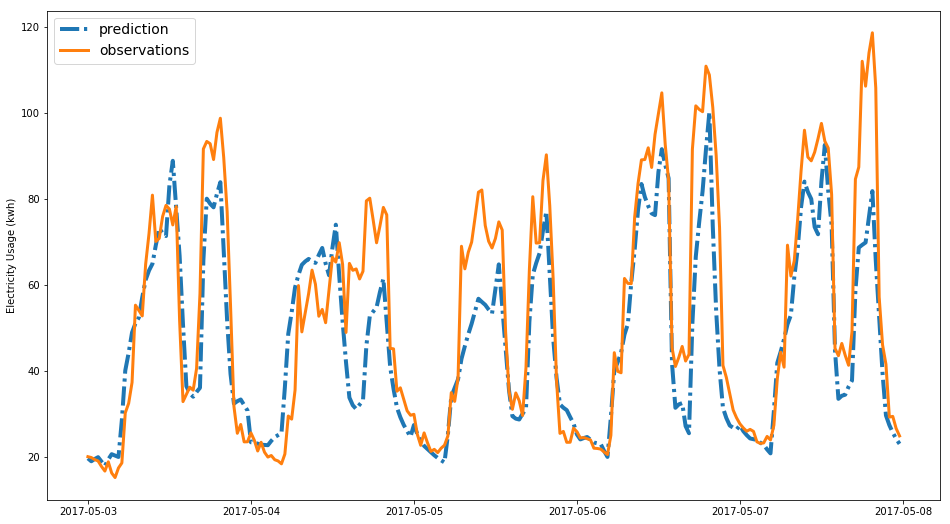

In [36]:
final_model = svm.SVR(kernel='rbf', C=1000).fit(df_X_train_scaled, y_train)
result_30min, df_err_30min = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_30min,
                                          test_set_dates, scale='30min')
dv.plot_pred(y_test_30min, result_30min)
df_err_30min

## Four hours

In [37]:
elec = read_data.elec(elec_data_path, scale='4H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,541.925,78.0,10.0
2017-01-15 04:00:00,545.675,78.0,10.0
2017-01-15 08:00:00,518.800,87.0,9.0
2017-01-15 12:00:00,480.300,81.0,10.0
2017-01-15 16:00:00,503.175,80.0,11.0


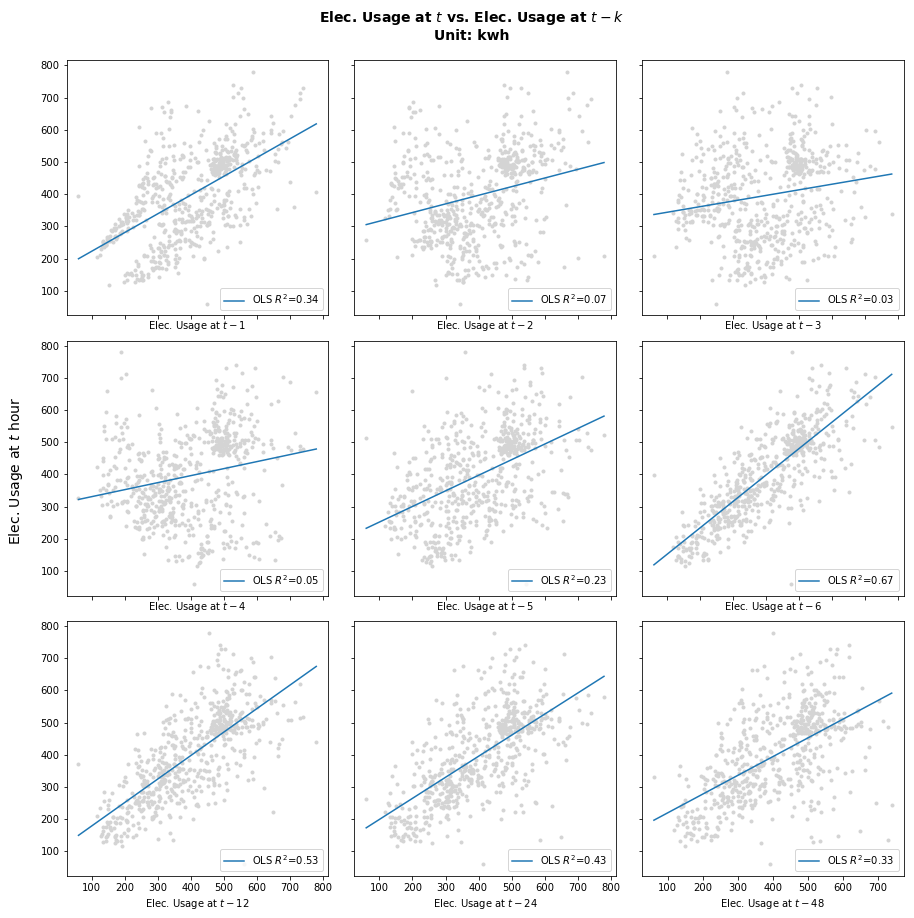

In [38]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [39]:
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
drop_col = ['kwh_t-1', 'kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-12', 'kwh_t-24', 'kwh_t-48', 1, 2, 3,
           5, 6, 7, 9, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22, 23]

In [40]:
X_train, y_train, X_cross, y_cross, X_test, y_test_4h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)
X_train.head(10)

,hum,tempm,kwh_t-6,0,4,8,12,16,20,if_holiday
stat_time,,,,,,,,,,
2017-01-23 00:00:00,84.0,6.0,575.175,1,0,0,0,0,0,0
2017-01-23 04:00:00,92.0,5.0,552.425,0,1,0,0,0,0,0
2017-01-23 08:00:00,96.0,4.0,546.425,0,0,1,0,0,0,0
2017-01-23 12:00:00,51.0,11.0,515.050,0,0,0,1,0,0,0
2017-01-23 16:00:00,27.0,17.0,508.050,0,0,0,0,1,0,0
2017-01-23 20:00:00,66.0,11.0,585.050,0,0,0,0,0,1,0
2017-01-24 00:00:00,88.0,8.0,581.550,1,0,0,0,0,0,0
2017-01-24 04:00:00,92.0,6.0,569.300,0,1,0,0,0,0,0
2017-01-24 08:00:00,95.0,7.0,530.050,0,0,1,0,0,0,0


In [41]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

** Grid Search **

In [42]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='4H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [43]:
search_result['linear']

C,1,10,100,1000
MAE,125.623429,153.554114,155.482557,155.483381
MAPE,27.869351,33.194450,33.588051,33.588560
RMSE,159.579939,192.106610,194.252547,194.252814


In [44]:
search_result['rbf']

MAE                                           MAPE             \
C             1           10          100         1000       1          10     
gamma                                                                          
0.0001  140.535810  139.996349  135.157405  110.759597  46.718447  46.381789   
0.0005  140.286484  137.913305  118.129567  124.695818  46.547024  45.463699   
0.001   140.003566  135.226279  110.923533  133.065251  46.386889  44.254069   
0.005   138.062454  118.584551  121.685809  128.970821  45.533471  34.667934   
0.01    135.877827  112.302219  126.168373  115.223188  44.619501  29.647072   
0.05    126.799516  102.054329  104.598828   95.188751  40.202416  23.782613   
0.1     125.239600   95.303487   97.552849   91.674500  39.894885  22.467457   
0.5     133.913649  100.969691   89.339433   87.443125  43.620252  28.446599   
auto    125.239600   95.303487   97.552849   91.674500  39.894885  22.467457   

                                    RMSE                                      
C            100        1000        1           10          100         1000  
gamma                                                                         
0.0001  44.214522  28.259029  159.252629  158.577371  152.819521  131.944046  
0.0005  34.059333  27.676243  158.935977  156.075505  135.757047  158.601970  
0.001   28.403124  29.129135  158.587303  152.907782  131.884596  168.389541  
0.005   27.058430  29.338925  156.271703  136.178495  155.289726  160.020535  
0.01    28.272073  27.476502  153.743206  131.676097  158.888197  141.940182  
0.05    25.529525  24.560101  143.970072  129.358606  130.136126  118.952066  
0.1     24.383456  23.710529  142.711143  120.404851  121.977171  117.190429  
0.5     23.323737  21.362427  152.253945  121.180860  110.314336  105.334791  
auto    24.383456  23.710529  142.711143  120.404851  121.977171  117.190429

In [45]:
search_result['poly']

MAE                                           MAPE             \
C             1           10          100         1000       1          10     
degree                                                                         
2       126.454043   80.679518   74.989519   83.554455  41.259242  22.951443   
3       128.032304   98.147266  112.418929  144.721798  40.446849  24.584615   
4       130.331312   91.204436   87.430057  110.503393  42.108288  23.303421   
5       133.360057   94.788729   99.936274  105.243468  42.582819  24.695819   
6       134.485947   96.313406  101.953468  116.842112  43.186326  25.464030   
7       134.974063  100.321467  100.573782  105.252267  43.124349  26.848820   

                                    RMSE                                      
C            100        1000        1           10          100         1000  
degree                                                                        
2       21.454264  23.385519  144.531527   94.554000   89.695576  104.721640  
3       27.070158  33.372805  144.565676  120.451040  133.811453  176.231181  
4       22.329521  28.448108  147.504397  113.698051  107.712701  134.468860  
5       24.877350  26.877253  150.479961  116.452238  122.856562  122.209727  
6       25.606632  29.219957  151.939661  118.288088  122.469390  140.525516  
7       25.270724  27.083369  152.438739  122.428847  120.558974  131.142214

** Final Test **

{'RMSE': 112.67001714251498, 'MAE': 90.98521062051046, 'MAPE': 23.684039247365714}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,118.176745,35.286122,123.923246,2407.664933,2834.613808,17.732903
2017-05-04,103.624746,32.546389,121.996129,2307.330127,2692.067502,16.674570
2017-05-05,58.534360,15.064053,78.585083,2320.526866,2671.733027,15.134760
2017-05-06,84.369162,17.992831,93.883035,2868.751045,2915.501761,1.629654
2017-05-07,90.221039,17.530801,135.066642,2836.405726,2645.237966,-6.739789


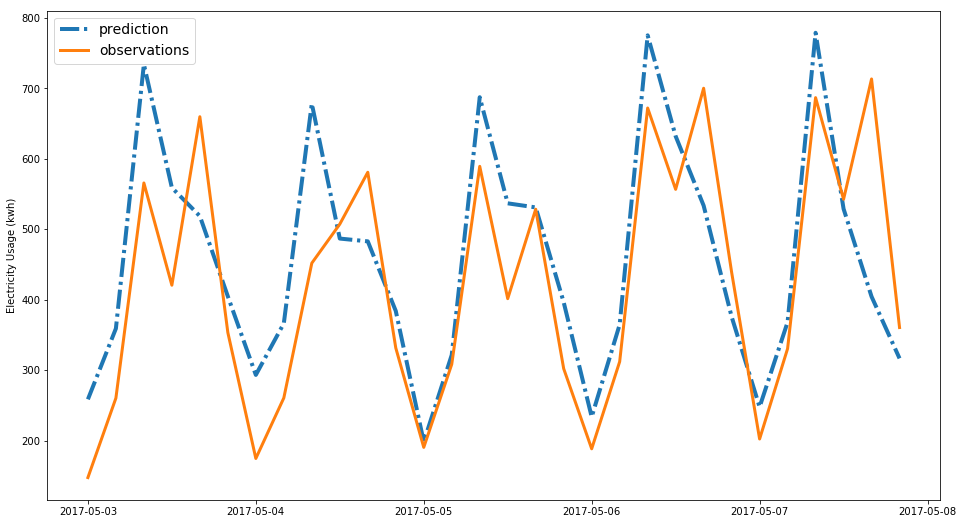

In [46]:
final_model = svm.SVR(kernel='poly', C=1500, degree=2).fit(df_X_train_scaled, y_train)
result_4h, df_err_4h = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_4h,
                                          test_set_dates, scale='4H')
dv.plot_pred(y_test_4h, result_4h)
df_err_4h

# 2 hours

In [47]:
elec = read_data.elec(elec_data_path, scale='2H')
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,268.900,78.0,10.0
2017-01-15 02:00:00,273.025,78.0,10.0
2017-01-15 04:00:00,275.025,78.0,10.0
2017-01-15 06:00:00,270.650,86.0,10.0
2017-01-15 08:00:00,267.900,87.0,9.0


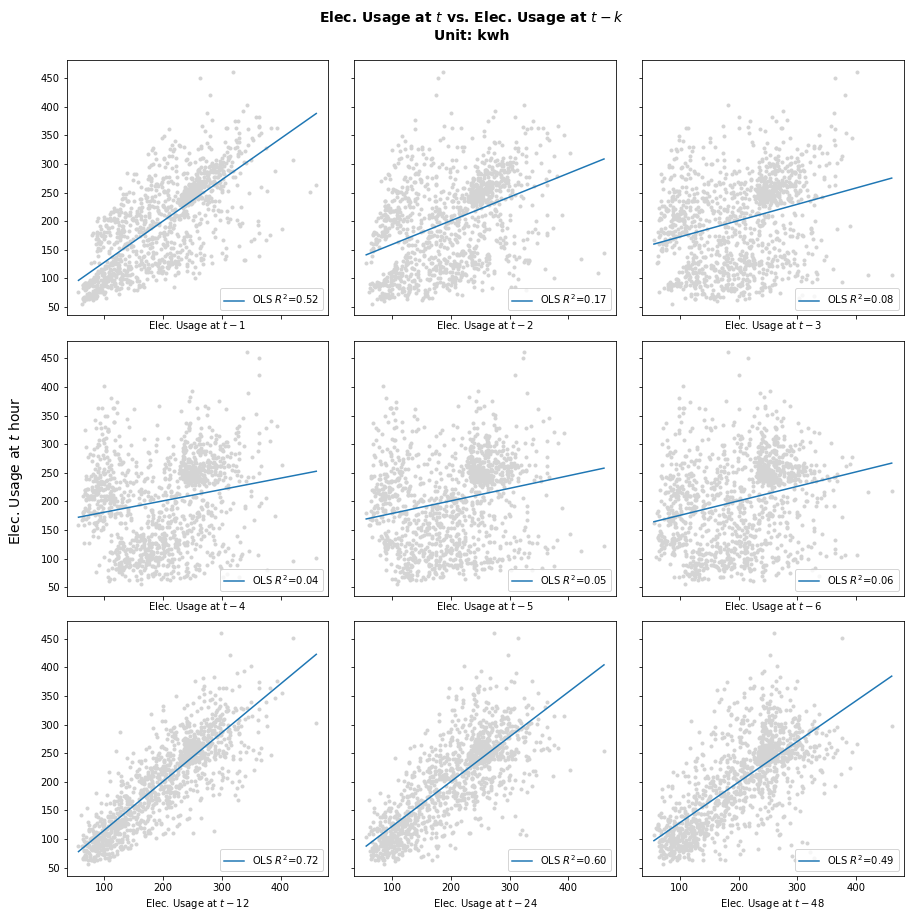

In [48]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [49]:
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
drop_col = ['kwh_t-1', 'kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-24', 'kwh_t-48', 1, 3,
           5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
X_train, y_train, X_cross, y_cross, X_test, y_test_2h = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)
X_train.head(13)

,hum,tempm,kwh_t-12,0,2,4,6,8,10,12,14,16,18,20,22,if_holiday
stat_time,,,,,,,,,,,,,,,,
2017-01-19 00:00:00,97.0,11.0,332.650,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-01-19 02:00:00,95.0,11.0,320.275,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-19 04:00:00,95.0,11.0,312.400,0,0,1,0,0,0,0,0,0,0,0,0,0
2017-01-19 06:00:00,95.0,10.0,313.900,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-01-19 08:00:00,97.0,10.0,299.025,0,0,0,0,1,0,0,0,0,0,0,0,0
2017-01-19 10:00:00,97.0,10.0,255.525,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-01-19 12:00:00,85.0,12.0,248.400,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-01-19 14:00:00,83.0,12.0,250.150,0,0,0,0,0,0,0,1,0,0,0,0,0
2017-01-19 16:00:00,83.0,12.0,245.400,0,0,0,0,0,0,0,0,1,0,0,0,0


In [50]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

** grid search **

In [51]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='2H')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [52]:
search_result['linear']

C,1,10,100,1000
MAE,73.147418,75.081705,75.592827,75.601677
MAPE,34.063348,34.455972,34.540708,34.543982
RMSE,93.818557,96.413927,97.100389,97.110033


In [53]:
search_result['rbf']

MAE                                        MAPE             \
C            1          10         100        1000       1          10     
gamma                                                                      
0.0001  81.093813  80.007790  70.096483  64.260733  59.973655  58.838142   
0.0005  80.581775  75.462691  59.643786  72.319967  59.401700  54.154062   
0.001   80.034137  70.316278  63.742246  69.617164  58.868689  48.644429   
0.005   75.950647  58.293469  65.799919  57.186777  54.694127  31.386465   
0.01    72.197588  59.318943  60.672556  52.283458  50.943050  30.334313   
0.05    63.085671  52.028152  51.699275  47.232946  41.786761  26.640322   
0.1     64.366697  46.531469  48.527148  44.553367  43.752113  24.266940   
0.5     75.876628  49.009169  43.857003  44.020524  54.893141  27.834239   
auto    62.980224  49.778851  50.864215  46.420134  42.084083  25.667926   

                                   RMSE                                   
C            100        1000       1          10         100        1000  
gamma                                                                     
0.0001  48.335521  32.163409  94.673019  93.511412  83.672211  82.007517  
0.0005  32.047657  33.807232  94.114663  88.821419  75.762847  92.874021  
0.001   31.970822  32.733039  93.540051  83.861014  81.368630  89.713273  
0.005   32.069066  31.026014  89.306894  74.299763  84.710999  72.558838  
0.01    30.687096  29.726487  85.502040  76.104392  77.733311  66.469752  
0.05    28.881021  26.184440  76.252911  68.207106  65.471922  58.904776  
0.1     26.787979  22.506350  77.253403  63.306474  61.351235  57.198104  
0.5     21.968517  22.505052  89.270012  64.177867  57.803967  55.496150  
auto    28.392260  25.273398  76.062572  65.874856  64.273713  58.048988

In [54]:
search_result['poly']

MAE                                           MAPE             \
C            1          10         100           1000       1          10     
degree                                                                        
2       64.373947  39.171833  40.060176  4.832441e+01  45.421497  23.061966   
3       64.878517  49.106866  51.340286  5.669534e+01  44.235703  26.655787   
4       66.510243  46.695812  48.225237  5.849683e+01  46.417431  25.531990   
5       68.727876  47.331488  48.505128  5.283275e+01  48.016319  26.374677   
6       70.317280  47.818858  48.324828  7.195887e+01  49.478488  26.969048   
7       72.612760  50.161755  46.105059  2.659281e+74  51.198083  28.964834   

                                      RMSE                                      
C            100           1000       1          10         100           1000  
degree                                                                          
2       24.101516  3.000067e+01  76.678789  48.109061  49.656846  6.195961e+01  
3       27.435070  2.952708e+01  78.115899  65.495359  65.430085  7.395014e+01  
4       26.101540  2.999960e+01  79.673503  63.500293  62.997274  7.562843e+01  
5       25.550956  2.796671e+01  81.741029  63.588422  62.659735  6.493119e+01  
6       25.150740  4.000312e+01  83.404836  63.818821  62.385924  1.003935e+02  
7       24.111363  1.848298e+74  85.866744  66.049413  59.446064  9.212019e+74

** final test **

{'RMSE': 58.547443596389286, 'MAE': 45.312067690459585, 'MAPE': 23.6129935373369}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,39.454582,27.237405,49.371049,2407.664933,2476.709513,2.867699
2017-05-04,28.604400,16.375443,35.868447,2307.330127,2249.468158,-2.507746
2017-05-05,40.731532,24.517526,48.275484,2320.526866,2175.437744,-6.252422
2017-05-06,56.350329,25.564251,67.010874,2868.751045,2579.379521,-10.087021
2017-05-07,61.419495,24.370343,81.203388,2836.405726,2323.756634,-18.073898


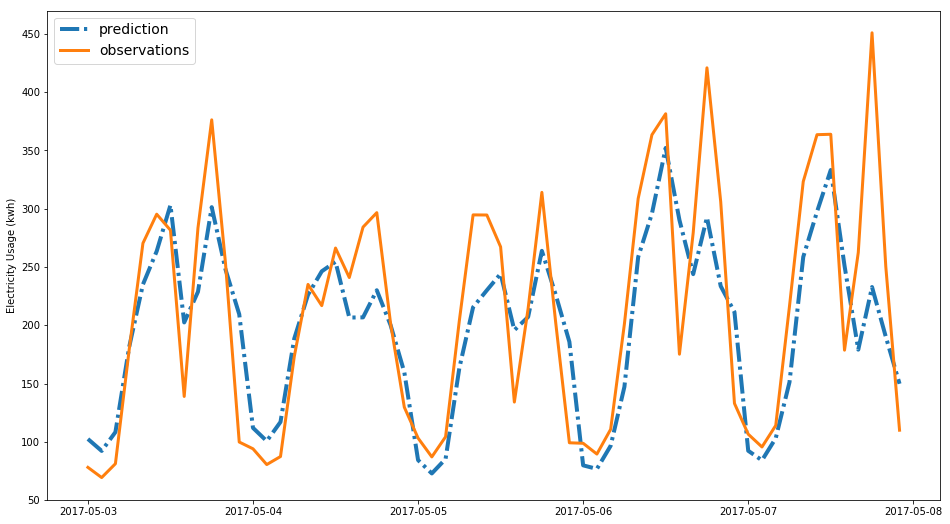

In [55]:
final_model = svm.SVR(kernel='rbf', C=1000, gamma=0.05).fit(df_X_train_scaled, y_train)
result_2h, df_err_2h = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_2h,
                                          test_set_dates, scale='2H')
dv.plot_pred(y_test_2h, result_2h)
df_err_2h

# 15min scale

In [56]:
elec = read_data.elec(elec_data_path)
weather = read_data.weather(weather_data_path)
big_data = read_data.merge_elec_and_weather(elec, weather, startDate='1/15/2017', endDate='5/7/2017')

elec_and_weather = read_data.drop_col(big_data, keep_columns=['kwh', 'tempm', 'hum'])
elec_and_weather.head()

,kwh,hum,tempm
stat_time,,,
2017-01-15 00:00:00,33.675,78.0,10.0
2017-01-15 00:15:00,33.050,NaN,NaN
2017-01-15 00:30:00,33.800,NaN,NaN
2017-01-15 00:45:00,33.175,NaN,NaN
2017-01-15 01:00:00,32.800,78.0,10.0


In [57]:
elec_and_weather = elec_and_weather.fillna(method='ffill')

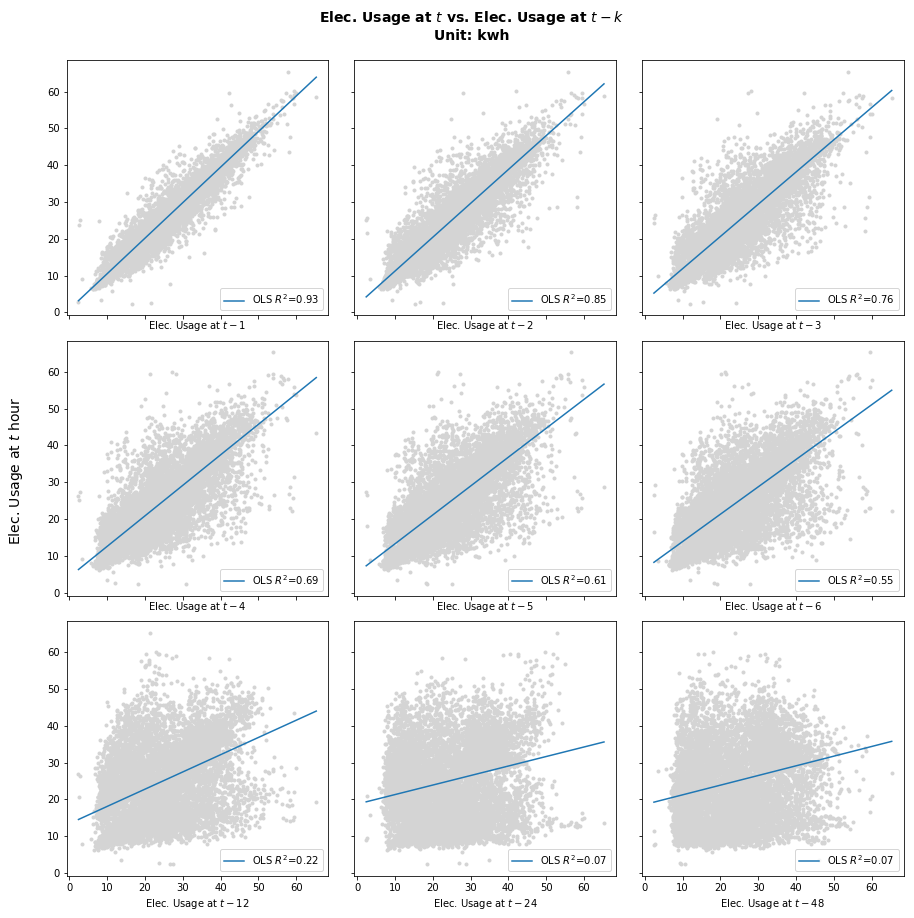

In [58]:
my_svr.add_historical_kwh(elec_and_weather)
dv.compare_t_t_k(elec_and_weather)

In [59]:
elec_and_weather['kwh_t-96'] = elec_and_weather['kwh'].shift(96)

In [60]:
my_svr.add_hour_of_day(elec_and_weather)
my_svr.add_if_holiday(elec_and_weather, holidays, workdays)
drop_col = ['kwh_t-2', 'kwh_t-3', 'kwh_t-4', 'kwh_t-5', 'kwh_t-6', 'kwh_t-12', 'kwh_t-24', 'kwh_t-48']
X_train, y_train, X_cross, y_cross, X_test, y_test_15min = my_svr.split(elec_and_weather.dropna(), split_date, drop_col)
X_train.head(5)

,hum,tempm,kwh_t-1,kwh_t-96,0,1,2,3,4,5,...,15,16,17,18,19,20,21,22,23,if_holiday
stat_time,,,,,,,,,,,,,,,,,,,,,
2017-01-17 00:00:00,92.0,9.0,37.675,35.175,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 00:15:00,92.0,9.0,38.175,34.175,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 00:30:00,92.0,9.0,37.550,34.550,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 00:45:00,92.0,9.0,37.550,33.175,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-17 01:00:00,92.0,9.0,37.800,32.050,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
scaler = preprocessing.StandardScaler().fit(X_train.append(X_cross))
X_train_scaled = scaler.transform(X_train)
X_cross_scaled = scaler.transform(X_cross)
X_test_scaled = scaler.transform(X_test)

df_X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
df_X_cross_scaled = pd.DataFrame(X_cross_scaled, index=X_cross.index, columns=X_cross.columns)
df_X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [62]:
parameters = {'kernel': ['linear', 'rbf', 'poly'], 
              'C': [1, 10, 100, 1000], 
              'gamma': ['auto', 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1],
             'degree': [2, 3, 4, 5, 6, 7]}
search_result = my_svr.grid_search(parameters, df_X_train_scaled, y_train, df_X_cross_scaled, y_cross, scaler, cross_set_dates,
                                  scale='15min')

Testing linear kernel...
Testing rbf kernel...
Testing poly kernel...
Done.


In [63]:
search_result['linear']

C,1,10,100,1000
MAE,11.519070,11.527997,11.531910,11.533517
MAPE,38.398325,38.414575,38.428138,38.432843
RMSE,15.238586,15.253511,15.257566,15.259708


In [64]:
search_result['rbf']

MAE                                        MAPE             \
C            1          10         100        1000       1          10     
gamma                                                                      
0.0001   9.076635   8.407064  11.089984  11.410571  53.062335  32.588081   
0.0005   7.440344  10.652234  11.328406  11.025736  31.654727  36.490015   
0.001    8.315730  11.020618  11.181330  10.870163  32.398555  37.126348   
0.005   10.335625  10.956920  10.827970  10.781119  35.663600  36.663391   
0.01    10.558491  10.845674  10.685737  10.484971  36.065156  36.429906   
0.05     9.322517   9.800983   9.701112   9.236304  33.882069  34.389138   
0.1      8.125026   8.818669   9.039045   8.602531  31.536412  32.102514   
0.5      7.159001   7.278134   7.385633   8.926233  30.695819  29.816532   
auto     9.891301  10.201448  10.098232   9.491863  34.988838  35.224417   

                                   RMSE                                   
C            100        1000       1          10         100        1000  
gamma                                                                     
0.0001  37.421444  38.033195  10.799767  11.075450  14.634371  15.105878  
0.0005  37.725819  36.707360   9.814552  14.019920  15.002893  14.664412  
0.001   37.237246  36.189059  10.963610  14.554292  14.836063  14.495166  
0.005   36.144458  35.867743  13.596444  14.522980  14.409631  14.405693  
0.01    35.824821  35.129669  13.895263  14.355886  14.216972  14.051639  
0.05    33.141820  32.652988  12.194278  12.914671  13.054304  12.534259  
0.1     32.138737  32.481664  10.693337  11.686544  12.138792  12.184415  
0.5     30.742443  39.161929   9.581477   9.726592   9.990845  11.962088  
auto    34.166283  32.907550  12.938505  13.442417  13.546901  12.777105

In [65]:
search_result['poly']

MAE                                        MAPE             \
C           1          10         100        1000       1          10     
degree                                                                    
2       5.927490   8.081409  13.407911  17.585533  29.314690  41.590939   
3       8.583320  10.659748  10.933630  10.616246  32.615469  36.062043   
4       8.288318  10.220304  10.841493  10.821637  30.900433  34.642122   
5       8.302838  10.281756  10.371612   9.697719  30.901425  34.650678   
6       8.262478  10.297597  10.206716   9.940906  30.717007  34.663515   
7       8.194467  10.224744  10.199226  10.597551  30.491532  34.428072   

                                   RMSE                                   
C            100        1000       1          10         100        1000  
degree                                                                    
2       58.455525  67.027568   7.810767  10.882724  20.089142  31.690000  
3       36.842396  36.253542  11.242578  14.209326  14.697669  14.223210  
4       35.859227  36.242331  10.988022  13.676359  14.780822  14.864396  
5       34.897189  34.268265  11.022263  13.821581  14.114904  13.539893  
6       34.360699  37.192456  10.976629  13.870060  13.952971  14.115580  
7       34.570089  41.762694  10.893148  13.785458  13.974670  16.104649

{'RMSE': 8.7444817807538353, 'MAE': 6.568774100774298, 'MAPE': 27.62069837178181}


,MAE,MAPE,RMSE,Obs,Pred,err%
stat_time,,,,,,
2017-05-03,7.183164,38.805299,8.562454,2407.664933,2612.998914,8.528345
2017-05-04,6.971941,32.647098,7.821227,2307.330127,2387.986386,3.495653
2017-05-05,4.681139,24.970491,6.233792,2320.526866,2502.866074,7.857664
2017-05-06,6.209070,18.952577,8.930614,2868.751045,2507.157532,-12.604562
2017-05-07,7.798556,22.728027,11.367787,2836.405726,2307.109654,-18.660803


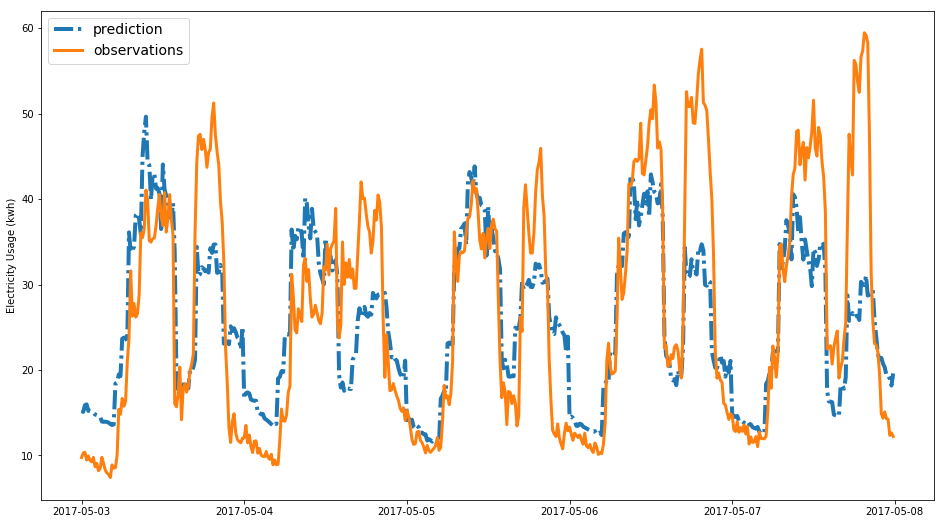

In [66]:
final_model = svm.SVR(kernel='poly', C=1, degree=2).fit(df_X_train_scaled, y_train)
result_15min, df_err_15min = my_svr.predict_many_days(final_model, scaler, df_X_test_scaled, y_test_15min,
                                          test_set_dates, scale='15min')
dv.plot_pred(y_test_15min, result_15min)
df_err_15min

# Plot result

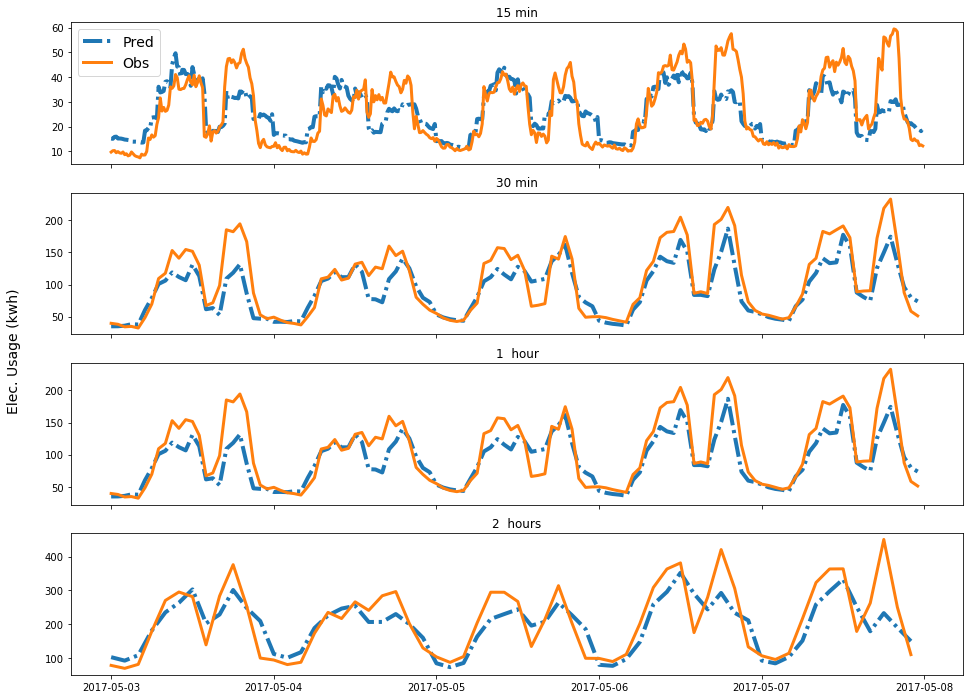

In [67]:
dv.plot_multiscale_result(result_15min, y_test_15min, result_30min, y_test_30min, result_1h, y_test_1h, result_2h, y_test_2h)